In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from tomopt.muon import *
from tomopt.inference import *
from tomopt.volume import *
from tomopt.core import *
from tomopt.optimisation import *
from tomopt.utils import *

import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np

import torch
from torch import Tensor, nn
import torch.nn.functional as F

# Basics

In [3]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

<ipython-input-4-edc514db5f58>:4: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(-10, 100*100)


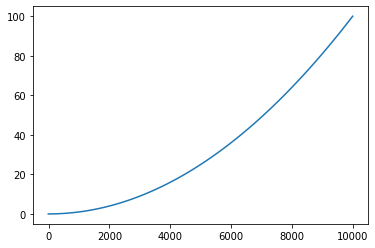

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x/1000)**2

x = torch.linspace(-10, 100*100)
plt.plot(x, area_cost(x))

# Detector panels

In [5]:
c = torch.tensor([0.5,0.5], requires_grad=True)
s = torch.tensor([0.5,1], requires_grad=True)

In [6]:
gauss = torch.distributions.Normal(c, s)

In [7]:
torch.prod(torch.exp(gauss.log_prob(Tensor([[0.5,0.5], [1,1]])))/torch.exp(gauss.log_prob(Tensor([0.5,0.5]))),dim=-1)

tensor([1.0000, 0.5353], grad_fn=<ProdBackward1>)

In [8]:
class DetectorPanel(nn.Module):
    def __init__(
        self,
        *,
        res: float,
        eff: float,
        init_xyz:Tuple[float,float,float],
        init_xy_span: Tuple[float,float],
        area_cost_func: Callable[[Tensor], Tensor],
        realistic_validation:bool=True,
        device: torch.device = DEVICE
    ):
        if res <= 0:
            raise ValueError(f'Resolution must be positive')
        if eff <= 0:
            raise ValueError(f'Efficiency must be positive')
            
        super().__init__()
        self.area_cost_func, self.realistic_validation, self.device = area_cost_func, realistic_validation, device
        self.register_buffer('resolution', torch.tensor(float(res), requires_grad=True, device=self.device))
        self.register_buffer('efficiency', torch.tensor(float(eff), requires_grad=True, device=self.device))
        self.xy = nn.Parameter(torch.tensor(init_xyz[:2], device=self.device))
        self.z = nn.Parameter(torch.tensor(init_xyz[2:3], device=self.device))
        self.xy_span = nn.Parameter(torch.tensor(init_xy_span, device=self.device))
        
    def __repr__(self) -> str:
        return f'''{self.__class__} located at xy={self.xy.data}, z={self.z.data}, and xy span {self.xy_span.data}'''
    
    def get_xy_mask(self, xy: Tensor) -> Tensor:
        xy_low = self.xy-(self.xy_span/2)
        xy_high = self.xy+(self.xy_span/2)
        return (xy[:,0] >= xy_low[0]) * (xy[:,0] < xy_high[0]) * (xy[:,1] >= xy_low[1]) * (xy[:,1] < xy_high[1])
    
    def get_gauss(self) -> torch.distributions.Normal:
        try:
            return torch.distributions.Normal(self.xy, self.xy_span)  # maybe upscale span?
        except ValueError:
            print(f'Invalid parameters for Gaussian: loc={self.xy}, scale={self.xy_span}'); assert False
    
    def get_resolution(self, xy:Tensor, mask:Optional[Tensor]=None) -> Tensor:
        if self.training or not self.realistic_validation:
            g = self.get_gauss()
            res = self.resolution*torch.exp(g.log_prob(xy))/torch.exp(g.log_prob(self.xy))  # Maybe detach the normalisation?
        else:
            if mask is None:
                mask = self.get_xy_mask(xy)
            res = torch.zeros((len(xy),2), device=self.device)  # Zero detection outside detector
            res[mask] = self.resolution
        return res
    
    def get_efficiency(self, xy:Tensor, mask:Optional[Tensor]=None) -> Tensor:
        if self.training or not self.realistic_validation:
            g = self.get_gauss()
            scale = torch.exp(g.log_prob(xy))/torch.exp(g.log_prob(self.xy))  # Maybe detach the normalisation?
            eff = self.efficiency*torch.prod(scale, dim=-1)  # Maybe weight product by xy distance?
        else:
            if mask is None:
                mask = self.get_xy_mask(xy)
            eff = torch.zeros(len(xy), device=self.device)  # Zero detection outside detector
            eff[mask] = self.efficiency
        return eff
        
    def get_hits(self, mu: MuonBatch) -> Dict[str, Tensor]:
        mask = mu.get_xy_mask(self.xy-(self.xy_span/2), self.xy+(self.xy_span/2))  # Muons in panel
        
        xy0 = self.xy-(self.xy_span/2)  # Low-left of voxel
        rel_xy = mu.xy - xy0
        res = self.get_resolution(mu.xy, mask)        
        rel_xy = rel_xy + (torch.randn((len(mu), 2), device=self.device) / res)
        
        if not self.training and self.realistic_validation:  # Prevent reco hit from exiting panel
            span = self.xy_span.detach().cpu().numpy()
            rel_xy[mask] = torch.stack([torch.clamp(rel_xy[mask][:,0], 0, span[0]),
                                        torch.clamp(rel_xy[mask][:,1], 0, span[1])], dim=-1)  
        reco_xy = xy0 + rel_xy

        hits = {
            "reco_xy": reco_xy,
            "gen_xy": mu.xy.detach().clone(),
            "z": self.z.expand_as(mu.x)[:, None],
        }
        return hits

    def get_cost(self) -> Tensor:
        return self.area_cost_func(self.xy_span.prod())
    
    def clamp_params(self, xyz_low:Tuple[float,float,float], xyz_high:Tuple[float,float,float]) -> None:
        with torch.no_grad():
            eps = np.random.uniform(0, 1e-5)  # prevent hits at same z due to clamping
            torch.clamp_(self.x, min=xyz_low[0], max=xyz_high[0])
            torch.clamp_(self.y, min=xyz_low[1], max=xyz_high[1])
            torch.clamp_(self.z, min=xyz_low[2]+eps, max=xyz_high[2]-eps)
            torch.clamp_(self.xy_span[0], min=1e-7, max=xyz_high[0])
            torch.clamp_(self.xy_span[1], min=1e-7, max=xyz_high[1])
    
    @property
    def x(self) -> Tensor:
        return self.xy[0]
    
    @property
    def y(self) -> Tensor:
        return self.xy[1]

In [9]:
from tomopt.volume.layer import Layer

class DetectorLayer(Layer):
    def __init__(
        self,
        pos: str,
        lw: Tensor,
        z: float,
        size: float,
        panels: nn.ModuleList,
        device: torch.device = DEVICE,
    ):
        super().__init__(lw=lw, z=z, size=size, device=device)
        if isinstance(panels, list):
            panels = nn.ModuleList(panels)
        self.pos, self.panels = pos, panels
    
    def get_panel_zorder(self) -> List[int]:
        return np.argsort([p.z.detach().cpu().item() for p in self.panels])[::-1]
        
    def conform_detector(self) -> None:
        lw = self.lw.detach().cpu().numpy()
        z = self.z.detach().cpu()[0]
        for p in self.panels:
            p.clamp_params(xyz_low=(0,0,z-self.size), xyz_high=(lw[0],lw[1],z))
                
    def forward(self, mu: MuonBatch) -> None:
        for i in self.get_panel_zorder():
            self.scatter_and_propagate(mu, mu.z-self.panels[i].z)  # Move to panel
            mu.append_hits(self.panels[i].get_hits(mu), self.pos)
        self.scatter_and_propagate(mu, mu.z-(self.z-self.size))  # Move to bottom of layer

    def get_cost(self) -> Tensor:
        for i, p in enumerate(self.panels):
            cost = p.get_cost() if i == 0 else cost + p.get_cost()
        return cost

In [10]:
panels = nn.ModuleList([DetectorPanel(res=1e4, eff=0.5, init_xyz=[0.5,0.5,0.95], init_xy_span=[0.5,0.5], area_cost_func=area_cost),
                        DetectorPanel(res=1e4, eff=0.5, init_xyz=[0.5,0.5,1.], init_xy_span=[0.5,0.5], area_cost_func=area_cost)])

In [11]:
a = nn.Module()

In [12]:
panels[0].get_gauss()

Normal(loc: torch.Size([2]), scale: torch.Size([2]))

In [14]:
panels[0].z.shape

torch.Size([1])

In [15]:
muons = MuonBatch(generate_batch(100), init_z=1.0)

In [16]:
muons.xy.grad

In [17]:
panels[0].get_hits(muons)

{'reco_xy': tensor([[0.7200, 0.1562],
         [0.9258, 0.3005],
         [0.1125, 0.6855],
         [0.0867, 0.5741],
         [0.0946, 0.0053],
         [0.8999, 0.5432],
         [0.0717, 0.5854],
         [0.7748, 0.1794],
         [0.3871, 0.9040],
         [0.7311, 0.1096],
         [0.3023, 0.3879],
         [0.1331, 0.8438],
         [0.8686, 0.3333],
         [0.8151, 0.5503],
         [0.8135, 0.2263],
         [0.5495, 0.2361],
         [0.8782, 0.1772],
         [0.0421, 0.9219],
         [0.7733, 0.4054],
         [0.6463, 0.7365],
         [0.0181, 0.1412],
         [0.3953, 0.5163],
         [0.5367, 0.5158],
         [0.5225, 0.7891],
         [0.2191, 0.6066],
         [0.6701, 0.0259],
         [0.2812, 0.1522],
         [0.8464, 0.6784],
         [0.5035, 0.5622],
         [0.5358, 0.8111],
         [0.4963, 0.9304],
         [0.2989, 0.1188],
         [0.1766, 0.9286],
         [0.8307, 0.6295],
         [0.3473, 0.2312],
         [0.0068, 0.7821],
         [0.6334,

In [18]:
muons.xy.grad

In [19]:
dl = DetectorLayer(pos='above', lw=Tensor([1,1]), z=1, size=0.1, panels=panels)

In [20]:
dl.get_cost()

tensor(1.2500e-07, grad_fn=<AddBackward0>)

In [21]:
dl.get_panel_zorder()

array([1, 0])

In [22]:
dl.panels

ModuleList(
  (0): <class '__main__.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([0.5000, 0.5000])
  (1): <class '__main__.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([0.5000, 0.5000])
)

In [23]:
dl(muons)

In [24]:
muons.xy.grad

In [25]:
muons.z

tensor([0.9000])

In [26]:
muons.hits

defaultdict(<function tomopt.muon.muon_batch.MuonBatch.__init__.<locals>.<lambda>()>,
            {'above': defaultdict(list,
                         {'reco_xy': [tensor([[0.7200, 0.1559],
                                   [0.9256, 0.3006],
                                   [0.1124, 0.6854],
                                   [0.0867, 0.5741],
                                   [0.0946, 0.0054],
                                   [0.8998, 0.5431],
                                   [0.0715, 0.5852],
                                   [0.7749, 0.1798],
                                   [0.3872, 0.9042],
                                   [0.7308, 0.1092],
                                   [0.3020, 0.3880],
                                   [0.1332, 0.8439],
                                   [0.8684, 0.3331],
                                   [0.8148, 0.5500],
                                   [0.8136, 0.2266],
                                   [0.5494, 0.2358],
               

In [27]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    n_panels = 4
    layers.append(DetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,1-(i*(2*size)/n_panels)], init_xy_span=[0.5,0.5],
                                                      area_cost_func=area_cost) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))
    layers.append(DetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,0.2-(i*(2*size)/n_panels)], init_xy_span=[0.5,0.5],
                                                      area_cost_func=area_cost) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [28]:
class Volume(nn.Module):
    def __init__(self, layers: nn.ModuleList):
        super().__init__()
        if isinstance(layers, list):
            layers = nn.ModuleList(layers)
        self.layers = layers

    def __getitem__(self, idx:int) -> Layer:
        return self.layers[idx]

    def get_detectors(self) -> List[DetectorLayer]:
        return [l for l in self.layers if isinstance(l, DetectorLayer)]

    def get_passives(self) -> List[PassiveLayer]:
        return [l for l in self.layers if isinstance(l, PassiveLayer)]

    def get_rad_cube(self) -> Tensor:
        vols = list(reversed(self.get_passives()))  # reversed to match lookup_xyz_coords: layer zero = bottom layer
        if len(vols) == 0:
            raise ValueError("self.layers contains no passive layers")
        return torch.stack([v.rad_length for v in vols if v.rad_length is not None], dim=0)

    def lookup_passive_xyz_coords(self, xyz: Tensor) -> Tensor:
        r"""Assume same size for all layers for now and no intermedeate detector layers"""
        if len(xyz.shape) == 1:
            xyz = xyz[None, :]

        if n := (
            ((xyz[:, :2] > self.lw) + (xyz[:, :2] < 0)).sum(1) + (xyz[:, 2] < self.get_passive_z_range()[0]) + ((xyz[:, 2] > self.get_passive_z_range()[1]))
        ).sum():
            raise ValueError(f"{n} Coordinates outside passive volume")
        xyz[:, 2] = xyz[:, 2] - self.get_passive_z_range()[0]
        return torch.floor(xyz / self.size).long()

    def load_rad_length(self, rad_length_func: Callable[..., Tensor]) -> None:
        for p in self.get_passives():
            p.load_rad_length(rad_length_func)

    def forward(self, mu: MuonBatch) -> None:  # Expand to take volume as input, too
        for l in self.layers:
            l(mu)
            mu.snapshot_xyz()

    def get_cost(self) -> Tensor:
        cost = None
        for l in self.layers:
            if hasattr(l, "get_cost"):
                if cost is None:
                    cost = l.get_cost()
                else:
                    cost = cost + l.get_cost()
        if cost is None:
            cost = torch.zeros((1))
        return cost

    @property
    def lw(self) -> Tensor:
        return self.get_passives()[-1].lw

    @property
    def passive_size(self) -> float:
        return self.get_passives()[-1].size  # Same size for each passive layer

    @property
    def h(self) -> float:
        return self.layers[0].z

    def get_passive_z_range(self) -> Tuple[Tensor, Tensor]:
        ps = self.get_passives()
        return ps[-1].z-self.passive_size, ps[0].z

In [29]:
volume = Volume(get_layers())

In [30]:
volume[0].panels

ModuleList(
  (0): <class '__main__.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([0.5000, 0.5000])
  (1): <class '__main__.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([0.5000, 0.5000])
  (2): <class '__main__.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([0.5000, 0.5000])
  (3): <class '__main__.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([0.5000, 0.5000])
)

In [31]:
for l in volume: print(l.z)

tensor([1.])
tensor([0.8000])
tensor([0.7000])
tensor([0.6000])
tensor([0.5000])
tensor([0.4000])
tensor([0.3000])
tensor([0.2000])


In [32]:
volume.get_passive_z_range()

(tensor([0.2000]), tensor([0.8000]))

In [33]:
volume[-1].panels

ModuleList(
  (0): <class '__main__.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.2000]), and xy span tensor([0.5000, 0.5000])
  (1): <class '__main__.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.1500]), and xy span tensor([0.5000, 0.5000])
  (2): <class '__main__.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.1000]), and xy span tensor([0.5000, 0.5000])
  (3): <class '__main__.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.0500]), and xy span tensor([0.5000, 0.5000])
)

In [34]:
volume[0].panels[0].training

True

In [35]:
volume.eval()

Volume(
  (layers): ModuleList(
    (0): DetectorLayer(
      (panels): ModuleList(
        (0): <class '__main__.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([0.5000, 0.5000])
        (1): <class '__main__.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([0.5000, 0.5000])
        (2): <class '__main__.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([0.5000, 0.5000])
        (3): <class '__main__.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([0.5000, 0.5000])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): DetectorLayer(
      (panels): ModuleList(
        (0): <class '__main__.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.2000]), and xy span tensor([0.5000, 0.50

In [36]:
volume[0].training

False

In [37]:
volume[0].panels.training

False

# Scatter inference

In [ ]:
# volume.train()
volume.eval()

In [ ]:
muons = MuonBatch(generate_batch(100), init_z=1.0)

In [ ]:
muons.xy.grad

In [ ]:
volume(muons)

In [ ]:
muons.xy.grad

In [ ]:
from tomopt.utils import jacobian
jacobian(above_hits[0], volume.get_detectors()[0].panels[0].xy, create_graph=True)[:10]

In [ ]:
from tomopt.utils import jacobian
jacobian(above_hits[0], volume.get_detectors()[0].panels[0].z, create_graph=True)[:10]

In [ ]:
[h[1] for h in above_hits]

In [ ]:
[h[4] for h in above_hits]

In [ ]:
def get_hit_uncs(dets: List[DetectorPanel], hits: List[Tensor]) -> List[Tensor]:
    res = []
    for l,h in zip(dets,hits):
        r = 1 / l.get_resolution(h[:,:2])
        res.append(torch.cat([r, torch.zeros((len(r),1), device=r.device)], dim=-1))
    return res

In [ ]:
uncs = get_hit_uncs(volume.get_detectors()[0].panels, above_gen_hits)

In [ ]:
uncs[0][:10]

In [ ]:
[u[4] for u in uncs]

In [ ]:
from tomopt.utils import jacobian

class PanelScatterBatch(ScatterBatch):
    @staticmethod
    def get_muon_trajectory(hit_list: List[Tensor], unc_list: List[Tensor]) -> Tensor:
        r"""
        hits = [muons,(x,y,z)]
        uncs = [(unc,unc,0)]

        Assume no uncertainty for z

        In eval mode:
            Muons with <2 hits within panels have NaN trajectory.
            Muons with >=2 hits in panels have valid trajectories
        """

        hits, uncs = torch.stack(hit_list, dim=1), torch.stack(unc_list, dim=1)
        hits = torch.where(torch.isinf(hits), torch.tensor([0.5], device=uncs.device), hits)

        stars, angles = [],[]
        for i in range(2):  # seperate x and y resolutions
            inv_unc2 = uncs[:, :, i:i+1] ** -2
            sum_inv_unc2 = inv_unc2.sum(dim=1)
            mean_xz = torch.sum(hits[:,:,[i,2]] * inv_unc2, dim=1) / sum_inv_unc2
            mean_xz_z = torch.sum(hits[:,:,[i,2]] * hits[:, :, 2:3] * inv_unc2, dim=1) / sum_inv_unc2
            mean_x = mean_xz[:, :1]
            mean_z = mean_xz[:, 1:]
            mean_x_z = mean_xz_z[:, :1]
            mean_z2 = mean_xz_z[:, 1:]

            stars.append((mean_x - ((mean_z * mean_x_z) / mean_z2)) / (1 - (mean_z.square() / mean_z2)))
            angles.append((mean_x_z - (stars[-1] * mean_z)) / mean_z2)

        xy_star = torch.cat(stars, dim=-1)
        angle = torch.cat(angles, dim=-1)

        def _calc_xyz(z: Tensor) -> Tensor:
            return torch.cat([xy_star + (angle * z), z], dim=-1)
        
        return _calc_xyz(hits[:, 1, 2:3]) - _calc_xyz(hits[:, 0, 2:3])
    
    @staticmethod
    def get_hit_uncs(zordered_panels: List[DetectorPanel], hits: List[Tensor]) -> List[Tensor]:
        res = []
        for l,h in zip(zordered_panels,hits):
            r = 1 / l.get_resolution(h[:,:2])
            res.append(torch.cat([r, torch.zeros((len(r),1), device=r.device)], dim=-1))
        return res
    
    def compute_tracks(self) -> None:
        # reco x, reco y, gen z, must be a list to allow computation of uncertainty
        self.above_hits = [torch.cat([self.hits["above"]["reco_xy"][:, i], self.hits["above"]["z"][:, i]], dim=-1) for i in range(self.hits["above"]["reco_xy"].shape[1])]
        self.below_hits = [torch.cat([self.hits["below"]["reco_xy"][:, i], self.hits["below"]["z"][:, i]], dim=-1) for i in range(self.hits["below"]["reco_xy"].shape[1])]
        self.above_gen_hits = [torch.cat([self.hits["above"]["gen_xy"][:, i], self.hits["above"]["z"][:, i]], dim=-1) for i in range(self.hits["above"]["gen_xy"].shape[1])]
        self.below_gen_hits = [torch.cat([self.hits["below"]["gen_xy"][:, i], self.hits["below"]["z"][:, i]], dim=-1) for i in range(self.hits["below"]["gen_xy"].shape[1])]
        self.n_hits_above = len(self.above_hits)
        
        self.above_hit_uncs = self.get_hit_uncs([self.volume.get_detectors()[0].panels[i] for i in self.volume.get_detectors()[0].get_panel_zorder()], self.above_gen_hits)
        self.below_hit_uncs = self.get_hit_uncs([self.volume.get_detectors()[1].panels[i] for i in self.volume.get_detectors()[1].get_panel_zorder()], self.below_gen_hits)
    
        self.track_in = self.get_muon_trajectory(self.above_hits, self.above_hit_uncs)
        self.track_out = self.get_muon_trajectory(self.below_hits, self.below_hit_uncs)
        
    def _compute_unc(self, var: Tensor, hits: List[Tensor], hit_uncs: List[Tensor]) -> Tensor:
        unc2_sum = None
        for i, (xi, unci) in enumerate(zip(hits, hit_uncs)):
            unci = torch.where(torch.isinf(unci), torch.tensor([0], device=unci.device).type(unci.type()), unci)[:, None]
            for j, (xj, uncj) in enumerate(zip(hits, hit_uncs)):
                if j < i:
                    continue
                uncj = torch.where(torch.isinf(uncj), torch.tensor([0], device=uncj.device).type(uncj.type()), uncj)[:, None]
                dv_dx_2 = torch.nan_to_num(jacobian(var, xi)).sum(2) * torch.nan_to_num(jacobian(var, xj)).sum(2) if i != j else torch.nan_to_num(jacobian(var, xi)).sum(2) ** 2  # Muons, var_xyz, hit_xyz
                unc_2 = (dv_dx_2 * unci * uncj).sum(2)  # Muons, (x,y,z)
                if unc2_sum is None:
                    unc2_sum = unc_2
                else:
                    unc2_sum = unc2_sum + unc_2
        return torch.sqrt(unc2_sum)

In [ ]:
sb = PanelScatterBatch(muons, volume)

In [ ]:
volume.get_detectors()[1].panels[2]

In [ ]:
sb.below_gen_hits[2]

In [ ]:
sb.below_hits[2][m]

In [ ]:
sb.location[:10], sb.location_unc[:10]

In [ ]:
m = sb.get_scatter_mask()

In [ ]:
sb.location[m][:10], sb.location_unc[m][:10]

# X0 inference

In [176]:
class PanelX0Inferer(X0Inferer):
    def compute_efficiency(self) -> Tensor:
        eff = None
        for pos, hits in enumerate([self.scatters.above_gen_hits, self.scatters.below_gen_hits]):
            leff = None
            layer = self.volume.get_detectors()[pos]
            panel_idxs = layer.get_panel_zorder()
            effs = torch.stack([layer.panels[i].get_efficiency(hits[i][self.mask,:2]) for i in panel_idxs], dim=0)
            for r in range(2,len(effs)+1):  # Muon goes through any combination of at least 2 panels
                c = torch.combinations(torch.arange(0,len(effs)), r=r)
                e = effs[c].prod(1).sum(0)  
                if leff is None:
                    leff = e
                else:
                    leff = leff + e
            if eff is None:
                eff = leff
            else:
                eff = eff * leff  # Muons detected above & below passive volume
        return eff

In [177]:
x0inf = PanelX0Inferer(sb)

In [178]:
eff = x0inf.compute_efficiency(); eff

tensor([0.5394, 2.3009, 2.4046, 0.9801, 0.1667, 0.5186, 0.7059, 3.6457, 0.9512,
        0.0834, 1.3470, 0.4952, 1.0162, 2.4188, 3.0825, 2.6382, 3.9940, 0.1769,
        0.7032, 0.4773, 1.2516, 0.4720, 2.8073, 3.4577, 2.1967, 0.7663, 1.6800,
        0.9756, 0.5301, 0.7971, 0.3570, 0.9761, 2.9537, 1.1144, 1.5421, 0.3635,
        0.3492, 0.5573, 0.1393, 0.8139, 1.7159, 0.4642, 1.2921, 3.1154, 1.5266,
        0.7198, 2.8771, 2.1837, 3.2252, 1.4048, 0.4979, 0.4454, 1.0287, 1.5097],
       grad_fn=<MulBackward0>)

## pred

In [179]:
pred_dtheta, pred_dtheta_unc = x0inf.x0_from_dtheta()

In [180]:
pred_dtheta.shape

torch.Size([54])

In [181]:
pred_dtheta[:10], pred_dtheta_unc[:10]

(tensor([0.0023, 0.0121, 0.0053, 0.0011, 0.0009, 0.0006, 0.0037, 0.0041, 0.0139,
         0.0030], grad_fn=<SliceBackward>),
 tensor([0.0021, 0.0197, 0.0062, 0.0006, 0.0006, 0.0003, 0.0045, 0.0038, 0.0285,
         0.0039], grad_fn=<SliceBackward>))

In [182]:
pred, weight = x0inf.average_preds(x0_dtheta=pred_dtheta, x0_dtheta_unc=pred_dtheta_unc, x0_dxy=None, x0_dxy_unc=None, efficiency=eff)

In [183]:
pred, weight = x0inf.pred_x0(False)
pred.shape, weight.shape

(torch.Size([6, 10, 10]), torch.Size([6, 10, 10]))

# Loss

In [239]:
muons = MuonBatch(generate_batch(2), init_z=1.0)

In [240]:
volume = Volume(get_layers())

In [241]:
volume.eval()

Volume(
  (layers): ModuleList(
    (0): DetectorLayer(
      (panels): ModuleList(
        (0): <class '__main__.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=1.0, and xy span tensor([0.5000, 0.5000])
        (1): <class '__main__.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=0.949999988079071, and xy span tensor([0.5000, 0.5000])
        (2): <class '__main__.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=0.8999999761581421, and xy span tensor([0.5000, 0.5000])
        (3): <class '__main__.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=0.8500000238418579, and xy span tensor([0.5000, 0.5000])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): DetectorLayer(
      (panels): ModuleList(
        (0): <class '__main__.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=0.20000000298023224, and xy span tensor([0.5000, 0.500

In [242]:
volume(muons)

In [243]:
sb = PanelScatterBatch(muons, volume)

In [244]:
sb.above_hits

[tensor([[-inf, -inf, 1.],
         [-inf, inf, 1.]], grad_fn=<CatBackward>),
 tensor([[  -inf,    inf, 0.9500],
         [  -inf,   -inf, 0.9500]], grad_fn=<CatBackward>),
 tensor([[  -inf,    inf, 0.9000],
         [   inf,   -inf, 0.9000]], grad_fn=<CatBackward>),
 tensor([[   inf,   -inf, 0.8500],
         [  -inf,    inf, 0.8500]], grad_fn=<CatBackward>)]

In [245]:
sb.location

tensor([[nan, nan, nan],
        [nan, nan, nan]], grad_fn=<AddBackward0>)

In [249]:
x0inf = PanelX0Inferer(sb)

In [250]:
pred, weight = x0inf.pred_x0(False)

In [251]:
pred

In [190]:
loss_func = DetectorLoss(0)

In [191]:
loss = loss_func(pred, weight, volume)

In [192]:
loss

tensor(1.4415, grad_fn=<AddBackward0>)

# VolumeWrapper

In [193]:
from functools import partial

In [252]:
from abc import ABCMeta, abstractmethod
from __future__ import annotations
from fastcore.all import Path
from typing import Callable, Iterator, Optional, List, Any, Tuple, Union
from fastprogress.fastprogress import ConsoleProgressBar, NBProgressBar, ProgressBar
from fastprogress import master_bar, progress_bar
import numpy as np

import torch
from torch import nn, Tensor

from tomopt.optimisation.callbacks.cyclic_callbacks import CyclicCallback
from tomopt.optimisation.callbacks.eval_metric import EvalMetric
from tomopt.optimisation.wrapper.volume_wrapper import FitParams

PartialOpt = Callable[[Iterator[nn.Parameter]], torch.optim.Optimizer]

class AbsVolumeWrapper(metaclass=ABCMeta):
    def __init__(
        self,
        volume: Volume,
        *,
        partial_opts: Dict[str, PartialOpt],
        loss_func: Optional[DetectorLoss],
        default_pred: Optional[float] = X0["beryllium"],
        mu_generator: Callable[[int], Tensor] = generate_batch,
        partial_scatter_inferer: Callable[[MuonBatch, Volume], ScatterBatch] = ScatterBatch,
        partial_x0_inferer: Callable[[ScatterBatch, bool], X0Inferer] = X0Inferer
    ):
        self.volume, self.loss_func, self.default_pred, self.mu_generator = volume, loss_func, default_pred, mu_generator
        self.partial_scatter_inferer, self.partial_x0_inferer = partial_scatter_inferer, partial_x0_inferer
        self._build_opt(**partial_opts)
        self.parameters = self.volume.parameters
    
    @abstractmethod
    def _build_opt(
        self, **kwargs
    ) -> None:
        r'''
        self.opts = {'res_opt': res_opt((l.resolution for l in self.volume.get_detectors())),
                     'eff_opt': eff_opt((l.efficiency for l in self.volume.get_detectors()))}
        '''
        pass

    def get_detectors(self) -> List[DetectorLayer]:
        return self.volume.get_detectors()

    def save(self, name: str) -> None:
        torch.save({"volume": self.volume.state_dict(), **{k:v.state_dict() for k,v in self.opts.items()}}, str(name))

    def load(self, name: str) -> None:
        state = torch.load(name, map_location="cuda" if torch.cuda.is_available() else "cpu")
        self.volume.load_state_dict(state["volume"])
        for k,v in state.items():
            if '_opt' in k: self.opts[k].load_state_dict(v)

    @classmethod
    def from_save(
        cls,
        name: str,
        *,
        partial_opts: Dict[str, PartialOpt],
        loss_func: Optional[DetectorLoss],
        default_pred: Optional[float] = X0["beryllium"],
        mu_generator: Callable[[int], Tensor] = generate_batch,
        partial_scatter_inferer: Callable[[MuonBatch, Volume], ScatterBatch] = ScatterBatch,
        partial_x0_inferer: Callable[[ScatterBatch, bool], X0Inferer] = X0Inferer
    ) -> VolumeWrapper:
        vw = cls(volume=volume, partial_opts=partial_opts, loss_func=loss_func, default_pred=default_pred, mu_generator=mu_generator, partial_scatter_inferer=partial_scatter_inferer, partial_x0_inferer=partial_x0_inferer)
        vw.load(name)
        return vw

    def get_param_count(self, trainable: bool = True) -> int:
        r"""
        Return number of parameters in detector.

        Arguments:
            trainable: if true (default) only count trainable parameters

        Returns:
            Number of (trainable) parameters in detector
        """

        return sum(p.numel() for p in self.parameters() if p.requires_grad or not trainable)

    def _scan_volume(self) -> None:
        # Scan volume with muon batches
        self.fit_params.wpreds, self.fit_params.weights = [], []
        if self.fit_params.state != "test":
            muon_bar = progress_bar(range(self.fit_params.n_mu_per_volume // self.fit_params.mu_bs), display=False, leave=False)
        else:
            muon_bar = progress_bar(range(self.fit_params.n_mu_per_volume // self.fit_params.mu_bs), parent=self.fit_params.passive_bar)
        for _ in muon_bar:
            self.fit_params.mu = MuonBatch(self.mu_generator(self.fit_params.mu_bs), init_z=self.volume.h)
            for c in self.fit_params.cbs:
                c.on_mu_batch_begin()
            self.volume(self.fit_params.mu)
            self.fit_params.sb = self.partial_scatter_inferer(self.fit_params.mu, self.volume)
            for c in self.fit_params.cbs:
                c.on_scatter_end()
            inferer = self.partial_x0_inferer(self.fit_params.sb, self.default_pred)
            pred, wgt = inferer.pred_x0(inc_default=False)
            if pred is not None:
                self.fit_params.wpreds.append(pred * wgt)
                self.fit_params.weights.append(wgt)
            for c in self.fit_params.cbs:
                c.on_mu_batch_end()

        # Predict volume based on all muon batches
        for c in self.fit_params.cbs:
            c.on_x0_pred_begin()
        if len(self.fit_params.wpreds) == 0:
            print('Warning: unable to scan volume with prescribed number of muons.')
            self.fit_params.weight = None
            self.fit_params.pred = None
        else:
            wgt = torch.stack(self.fit_params.weights, dim=0).sum(0)
            pred = torch.stack(self.fit_params.wpreds, dim=0).sum(0) / wgt
            if self.fit_params.use_default_pred:
                pred, wgt = inferer.add_default_pred(pred, wgt)
            self.fit_params.weight = wgt
            self.fit_params.pred = pred

        for c in self.fit_params.cbs:
            c.on_x0_pred_end()

        # Compute loss for volume
        if self.fit_params.state != "test" and self.loss_func is not None and self.fit_params.pred is not None:
            loss = self.loss_func(pred_x0=self.fit_params.pred, pred_weight=self.fit_params.weight, volume=self.volume)
            if self.fit_params.loss_val is None:
                self.fit_params.loss_val = loss
            else:
                self.fit_params.loss_val = self.fit_params.loss_val + loss

    def _scan_volumes(self, passives: PassiveYielder) -> None:
        if self.fit_params.state == "test":
            self.fit_params.passive_bar = master_bar(passives)
        for i, passive in enumerate(self.fit_params.passive_bar if self.fit_params.state == "test" else passives):
            self.fit_params.volume_id = i
            if self.fit_params.state != "test" and i % self.fit_params.passive_bs == 0:  # Volume batch start
                self.fit_params.loss_val = None
                for c in self.fit_params.cbs:
                    c.on_volume_batch_begin()

            self.volume.load_rad_length(passive)
            for c in self.fit_params.cbs:
                c.on_volume_begin()
            self._scan_volume()
            for c in self.fit_params.cbs:
                c.on_volume_end()

            if self.fit_params.state != "test" and (i + 1) % self.fit_params.passive_bs == 0:  # Volume batch end
                if self.fit_params.loss_val is not None:
                    self.fit_params.mean_loss = self.fit_params.loss_val / self.fit_params.passive_bs
                for c in self.fit_params.cbs:
                    c.on_volume_batch_end()

                if self.fit_params.state == "train":
                    # Compute update step
                    for o in self.opts.values():
                        o.zero_grad()
                    for c in self.fit_params.cbs:
                        c.on_backwards_begin()
                    self.fit_params.mean_loss.backward()
                    for c in self.fit_params.cbs:
                        c.on_backwards_end()        
                    for o in self.opts.values():
                        o.step()
                    for d in self.volume.get_detectors():
                        d.conform_detector()
                        
#                     for d in self.volume.get_detectors():
#                         for p in d.panels:
#                             print('xy', p.xy.data, p.xy.grad)
#                             print('z', p.z.data, p.z.grad)
#                     for d in self.volume.get_detectors():
#                         for p in d.panels:
#                             print('xy_span', p.xy_span.data, p.xy_span.grad)

                if len(passives) - (i + 1) < self.fit_params.passive_bs:
                    break

    def _fit_epoch(self) -> None:
        def run_epoch(passives: PassiveYielder) -> None:
            for c in self.fit_params.cbs:
                c.on_epoch_begin()
            self._scan_volumes(passives)
            for c in self.fit_params.cbs:
                c.on_epoch_end()

        self.fit_params.epoch += 1
        # Training
        self.volume.train()
        self.fit_params.state = "train"
        run_epoch(self.fit_params.trn_passives)

        # Validation
        if self.fit_params.val_passives is not None:
            self.volume.eval()
            self.fit_params.state = "valid"
            run_epoch(self.fit_params.val_passives)

    @staticmethod
    def _sort_cbs(cbs: List[Callback]) -> Tuple[List[CyclicCallback], Optional[MetricLogger], Optional[List[EvalMetric]]]:
        cyclic_cbs, metric_log, metric_cbs = [], None, []
        for c in cbs:
            if isinstance(c, CyclicCallback):
                cyclic_cbs.append(c)  # CBs that might prevent a wrapper from stopping training due to a hyper-param cycle
            if isinstance(c, MetricLogger):
                metric_log = c  # CB that logs losses and eval_metrics
            if isinstance(c, EvalMetric):
                metric_cbs.append(c)  # CB that computes additional performance metrics
        return cyclic_cbs, metric_log, metric_cbs

    def fit(
        self,
        n_epochs: int,
        passive_bs: int,
        n_mu_per_volume: int,
        mu_bs: int,
        trn_passives: PassiveYielder,
        val_passives: Optional[PassiveYielder],
        cbs: Optional[List[Callback]] = None,
        cb_savepath: Path = Path("train_weights"),
    ) -> List[Callback]:

        if cbs is None:
            cbs = []
        cyclic_cbs, metric_log, metric_cbs = self._sort_cbs(cbs)

        self.fit_params = FitParams(
            cbs=cbs,
            cyclic_cbs=cyclic_cbs,
            metric_log=metric_log,
            metric_cbs=metric_cbs,
            stop=False,
            n_epochs=n_epochs,
            mu_bs=mu_bs,
            n_mu_per_volume=n_mu_per_volume,
            cb_savepath=Path(cb_savepath),
            trn_passives=trn_passives,
            val_passives=val_passives,
            passive_bs=passive_bs,
        )
        self.fit_params.cb_savepath.mkdir(parents=True, exist_ok=True)
        try:
            for c in self.fit_params.cbs:
                c.set_wrapper(self)
            for c in self.fit_params.cbs:
                c.on_train_begin()
            self.fit_params.epoch_bar = progress_bar(range(self.fit_params.n_epochs))
            for e in self.fit_params.epoch_bar:
                self._fit_epoch()
                if self.fit_params.stop:
                    break
            for c in self.fit_params.cbs:
                c.on_train_end()
        finally:
            self.fit_params = None
            torch.cuda.empty_cache()
        return cbs

    def predict(
        self,
        passives: PassiveYielder,
        n_mu_per_volume: int,
        mu_bs: int,
        use_default_pred: bool = False,
        pred_cb: PredHandler = PredHandler(),
        cbs: Optional[List[Callback]] = None,
        cb_savepath: Path = Path("train_weights"),
    ) -> List[Tuple[np.ndarray, np.ndarray]]:
        if cbs is None:
            cbs = []
        cbs.append(pred_cb)
        passives.shuffle = False

        self.fit_params = FitParams(
            n_mu_per_volume=n_mu_per_volume,
            mu_bs=mu_bs,
            cbs=cbs,
            tst_passives=passives,
            state="test",
            cb_savepath=cb_savepath,
            use_default_pred=use_default_pred,
        )
        try:
            for c in self.fit_params.cbs:
                c.set_wrapper(self)
            self.volume.eval()
            for c in self.fit_params.cbs:
                c.on_pred_begin()
            self._scan_volumes(self.fit_params.tst_passives)
            for c in self.fit_params.cbs:
                c.on_pred_end()
        finally:
            self.fit_params = None
            cbs.pop()  # Remove pred_cb to avoid mutating cbs
            torch.cuda.empty_cache()
        return pred_cb.get_preds()

    def get_opt_lr(self, opt:str) -> float:
        return self.opts[opt].param_groups[0]["lr"]

    def set_opt_lr(self, lr: float, opt:str) -> None:
        self.opts[opt].param_groups[0]["lr"] = lr

    def get_opt_mom(self, opt:str) -> float:
        if "betas" in self.opts[opt].param_groups[0]:
            return self.opts[opt].param_groups[0]["betas"][0]
        else:
            return self.opts[opt].param_groups[0]["momentum"]

    def set_opt_mom(self, mom: float, opt:str) -> None:
        if "betas" in self.opts[opt].param_groups[0]:
            self.opts[opt].param_groups[0]["betas"] = (mom, self.opts[opt].param_groups[0]["betas"][1])
        else:
            self.opts[opt].param_groups[0]["momentum"] = mom

In [253]:
class VolumeWrapper(AbsVolumeWrapper):
    def __init__(
        self,
        volume: Volume,
        *,
        res_opt: PartialOpt,
        eff_opt: PartialOpt,
        loss_func: Optional[DetectorLoss],
        default_pred: Optional[float] = X0["beryllium"],
        mu_generator: Callable[[int], Tensor] = generate_batch,
    ):
        super().__init__(volume=volume, partial_opts={'res_opt':res_opt, 'eff_opt':eff_opt}, loss_func=loss_func, default_pred=default_pred,
                         mu_generator=mu_generator, partial_scatter_inferer=ScatterBatch, partial_x0_inferer=X0Inferer)

    def _build_opt(
        self, res_opt: PartialOpt, eff_opt: PartialOpt
    ) -> None:
        self.opts = {'res_opt': res_opt((l.resolution for l in self.volume.get_detectors())),
                     'eff_opt': eff_opt((l.efficiency for l in self.volume.get_detectors()))}
        
    @classmethod
    def from_save(
        cls,
        name: str,
        *,
        partial_opts: Dict[str, PartialOpt],
        loss_func: Optional[DetectorLoss],
        default_pred: Optional[float] = X0["beryllium"],
        mu_generator: Callable[[int], Tensor] = generate_batch,
    ) -> VolumeWrapper:
        return super().from_save(name, partial_opts={'res_opt':res_opt, 'eff_opt':eff_opt}, loss_func=loss_func, default_pred=default_pred,
                                 mu_generator=mu_generator, partial_scatter_inferer=ScatterBatch, partial_x0_inferer=X0Inferer)

In [254]:

class PanelVolumeWrapper(AbsVolumeWrapper):
    def __init__(
        self,
        volume: Volume,
        *,
        xy_pos_opt: PartialOpt,
        z_pos_opt: PartialOpt,
        xy_span_opt: PartialOpt,
        loss_func: Optional[DetectorLoss],
        default_pred: Optional[float] = X0["beryllium"],
        mu_generator: Callable[[int], Tensor] = generate_batch,
    ):
        super().__init__(volume=volume, partial_opts={'xy_pos_opt':xy_pos_opt, 'z_pos_opt':z_pos_opt, 'xy_span_opt':xy_span_opt}, loss_func=loss_func, default_pred=default_pred,
                         mu_generator=mu_generator, partial_scatter_inferer=PanelScatterBatch, partial_x0_inferer=PanelX0Inferer)

    def _build_opt(
        self, xy_pos_opt: PartialOpt, z_pos_opt: PartialOpt, xy_span_opt: PartialOpt
    ) -> None:
        self.opts = {'xy_pos_opt': xy_pos_opt((p.xy for l in self.volume.get_detectors() for p in l.panels)),
                     'z_pos_opt': z_pos_opt((p.z for l in self.volume.get_detectors() for p in l.panels)),
                     'xy_span_opt': xy_span_opt((p.xy_span for l in self.volume.get_detectors() for p in l.panels))}
        
    @classmethod
    def from_save(
        cls,
        name: str,
        *,
        partial_opts: Dict[str, PartialOpt],
        loss_func: Optional[DetectorLoss],
        default_pred: Optional[float] = X0["beryllium"],
        mu_generator: Callable[[int], Tensor] = generate_batch,
    ) -> VolumeWrapper:
        return super().from_save(name, partial_opts={'xyz_opt':xyz_opt, 'xy_span_opt':xy_span_opt}, loss_func=loss_func, default_pred=default_pred,
                                 mu_generator=mu_generator, partial_scatter_inferer=PanelScatterBatch, partial_x0_inferer=PanelX0Inferer)

class PanelDetectorLoss(nn.Module):
    def __init__(self, cost_coef: Optional[float] = None):
        super().__init__()
        self.cost_coef = cost_coef
        self.sub_losses: Dict[str, Tensor] = {}  # Store subcomponents in dict for telemetry

    def _compute_cost_coef(self, cost: Tensor, inference: Tensor) -> None:
        self.cost_coef = inference.detach() / cost.detach()

    def forward(self, pred_x0: Tensor, pred_weight: Tensor, volume: Volume) -> Tensor:
        true_x0 = volume.get_rad_cube()
        inference = torch.mean(pred_x0 - true_x0).pow(2)
        self.sub_losses["error"] = inference
        cost = volume.get_cost()
        if self.cost_coef is None:
            self._compute_cost_coef(cost, inference)
        self.sub_losses["cost"] = self.cost_coef * cost
        return self.sub_losses["error"] + self.sub_losses["cost"]

In [283]:
from fastprogress.fastprogress import IN_NOTEBOOK
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import List, Dict, Tuple, Optional
from collections import defaultdict

if IN_NOTEBOOK:
    from IPython.display import display
    
from tomopt.optimisation.callbacks.callback import Callback

class MetricLogger(Callback):
    r"""
    Provides live feedback during training showing a variety of metrics to help highlight problems or test hyper-parameters without completing a full training.
    If `show_plots` is false, will instead print training and validation losses at the end of each epoch.
    The full history is available as a dictionary by calling `MetricLogger.get_loss_history`.
    """

    tk_sz = 16
    tk_col = "black"
    lbl_sz = 24
    lbl_col = "black"
    leg_sz = 16
    cat_palette = "tab10"
    style = {"style": "whitegrid", "rc": {"patch.edgecolor": "none"}}
    h_mid = 8
    w_mid = h_mid * 16 / 9

    def __init__(self, show_plots: bool = IN_NOTEBOOK):
        self.show_plots = show_plots

    def _reset(self) -> None:
        self.loss_vals: Dict[str, List[float]] = {"Training": [], "Validation": []}
        self.sub_losses: Dict[str, List[float]] = defaultdict(list)
        self.best_loss: float = math.inf
        self.val_epoch_results: Optional[Tuple[float, Optional[float]]] = None
        self.metric_cbs: List[EvalMetric] = []
        self.n_trn_batches = len(self.wrapper.fit_params.trn_passives) // self.wrapper.fit_params.passive_bs

        self.metric_vals: List[List[float]] = [[] for _ in self.wrapper.fit_params.metric_cbs]
        self.main_metric_idx: Optional[int] = None
        self.lock_to_metric: bool = False
        if len(self.wrapper.fit_params.metric_cbs) > 0:
            self.main_metric_idx = 0
            for i, c in enumerate(self.wrapper.fit_params.metric_cbs):
                if c.main_metric:
                    self.main_metric_idx = i
                    self.lock_to_metric = True
                    break
        self._prep_plots()
        self.display = display(self.fig, display_id=True)
        
    def _build_grid_spec(self) -> mpl.gridspec.GridSpec:
        return self.fig.add_gridspec(3 + (self.main_metric_idx is None), 1)

    def _prep_plots(self) -> None:
        if self.show_plots:
            with sns.axes_style(**self.style):
                self.fig = plt.figure(figsize=(self.w_mid, self.w_mid), constrained_layout=True)
                self.grid_spec = self._build_grid_spec()
                self.loss_ax = self.fig.add_subplot(self.grid_spec[:3, :])
                self.sub_loss_ax = self.fig.add_subplot(self.grid_spec[3:4, :])
                if self.main_metric_idx is not None:
                    self.metric_ax = self.fig.add_subplot(self.grid_spec[4:5, :])
                for ax in [self.loss_ax, self.sub_loss_ax]:
                    ax.tick_params(axis="x", labelsize=0.8 * self.tk_sz, labelcolor=self.tk_col)
                    ax.tick_params(axis="y", labelsize=0.8 * self.tk_sz, labelcolor=self.tk_col)
                self.sub_loss_ax.set_xlabel("Epoch", fontsize=0.8 * self.lbl_sz, color=self.lbl_col)
                self.loss_ax.set_ylabel("Loss", fontsize=0.8 * self.lbl_sz, color=self.lbl_col)
                self.sub_loss_ax.set_ylabel("Loss Composition", fontsize=0.8 * self.lbl_sz, color=self.lbl_col)
                if self.main_metric_idx is not None:
                    self.metric_ax.tick_params(axis="x", labelsize=0.8 * self.tk_sz, labelcolor=self.tk_col)
                    self.metric_ax.tick_params(axis="y", labelsize=0.8 * self.tk_sz, labelcolor=self.tk_col)
                    self.metric_ax.set_xlabel("Epoch", fontsize=0.8 * self.lbl_sz, color=self.lbl_col)
                    self.metric_ax.set_ylabel(self.wrapper.fit_params.metric_cbs[self.main_metric_idx].name, fontsize=0.8 * self.lbl_sz, color=self.lbl_col)

    def on_train_begin(self) -> None:
        r"""
        Prepare for new training
        """

        super().on_train_begin()
        self._reset()

    def on_epoch_begin(self) -> None:
        r"""
        Prepare to track new loss
        """

        self.tmp_loss, self.batch_cnt, self.volume_cnt = 0, 0, 0
        self.tmp_sub_losses: Dict[str, float] = defaultdict(float)

    def on_volume_end(self) -> None:
        if self.wrapper.fit_params.state == "valid" and self.wrapper.loss_func is not None and hasattr(self.wrapper.loss_func, "sub_losses"):
            for k, v in self.wrapper.loss_func.sub_losses.items():
                self.tmp_sub_losses[k] += v.data.item()
            self.volume_cnt += 1

    def on_backwards_end(self) -> None:
        if self.wrapper.fit_params.state == "train":
            self.loss_vals["Training"].append(self.wrapper.fit_params.mean_loss.data.item())

    def on_volume_batch_end(self) -> None:
        if self.wrapper.fit_params.state == "valid":
            self.tmp_loss += self.wrapper.fit_params.mean_loss.data.item()
            self.batch_cnt += 1

    def on_epoch_end(self) -> None:
        r"""
        If validation epoch finished, record validation losses, compute info and update plots
        """

        if self.wrapper.fit_params.state == "valid":
            self.loss_vals["Validation"].append(self.tmp_loss / self.batch_cnt)
            for k, v in self.tmp_sub_losses.items():
                self.sub_losses[k].append(v / (self.loss_vals["Validation"][-1] * self.volume_cnt))  # Fractional components

            for i, c in enumerate(self.wrapper.fit_params.metric_cbs):
                self.metric_vals[i].append(c.get_metric())
            if self.loss_vals["Validation"][-1] <= self.best_loss:
                self.best_loss = self.loss_vals["Validation"][-1]

            if self.show_plots:
                self.update_plot()
                self.display.update(self.fig)
            else:
                self.print_losses()

            m = None
            if self.lock_to_metric:
                m = self.metric_vals[self.main_metric_idx][-1]
                if not self.wrapper.fit_params.metric_cbs[self.main_metric_idx].lower_metric_better:
                    m *= -1
            self.val_epoch_results = self.loss_vals["Validation"][-1], m

    def print_losses(self) -> None:
        r"""
        Print training and validation losses for the last epoch
        """

        p = f'Epoch {len(self.loss_vals["Validation"])}: '
        p += f'Training = {np.mean(self.loss_vals["Training"][-self.n_trn_batches:]):.2E} | '
        p += f'Validation = {self.loss_vals["Validation"][-1]:.2E}'
        for m, v in zip(self.wrapper.fit_params.metric_cbs, self.metric_vals):
            p += f" {m.name} = {v[-1]:.2E}"
        print(p)

    def update_plot(self) -> None:
        r"""
        Updates the plot(s).
        """

        # Loss
        self.loss_ax.clear()
        self.sub_loss_ax.clear()
        with sns.axes_style(**self.style), sns.color_palette(self.cat_palette):
            self.loss_ax.plot(
                (1 / self.n_trn_batches)
                + np.linspace(0, len(self.loss_vals["Validation"]), self.n_trn_batches * len(self.loss_vals["Validation"]), endpoint=False),
                self.loss_vals["Training"],
                label="Training",
            )
            x = range(1, len(self.loss_vals["Validation"]) + 1)
            self.loss_ax.plot(x, self.loss_vals["Validation"], label="Validation")
            keys = sorted([k for k in self.sub_losses])
            self.sub_loss_ax.stackplot(x, *[self.sub_losses[k] for k in keys], labels=keys)
            self.loss_ax.plot([1 / self.n_trn_batches, x[-1]], [self.best_loss, self.best_loss], label=f"Best = {self.best_loss:.3E}", linestyle="--")
            self.loss_ax.legend(loc="upper right", fontsize=0.8 * self.leg_sz)
            self.sub_loss_ax.legend(loc="upper left", fontsize=0.8 * self.leg_sz)
            for ax in [self.loss_ax, self.sub_loss_ax]:
                ax.grid(True, which="both")
                ax.set_xlim(1 / self.n_trn_batches, x[-1])
            self.sub_loss_ax.set_xlabel("Epoch", fontsize=0.8 * self.lbl_sz, color=self.lbl_col)
            self.loss_ax.set_ylabel("Loss", fontsize=0.8 * self.lbl_sz, color=self.lbl_col)
            self.sub_loss_ax.set_ylabel("Loss Composition", fontsize=0.8 * self.lbl_sz, color=self.lbl_col)

        if len(self.loss_vals["Validation"]) > 1:
            # Metrics
            if self.main_metric_idx is not None:
                self.metric_ax.clear()
                with sns.axes_style(**self.style), sns.color_palette(self.cat_palette) as palette:
                    x = range(self.n_trn_batches, self.n_trn_batches * len(self.loss_vals["Validation"]) + 1, self.n_trn_batches)
                    y = self.metric_vals[self.main_metric_idx]
                    self.metric_ax.plot(x, y, color=palette[1])
                    best = np.nanmin(y) if self.wrapper.fit_params.metric_cbs[self.main_metric_idx].lower_metric_better else np.nanmax(y)
                    self.metric_ax.plot([1, x[-1]], [best, best], label=f"Best = {best:.3E}", linestyle="--", color=palette[2])
                    self.metric_ax.legend(loc="upper left", fontsize=0.8 * self.leg_sz)
                    self.metric_ax.grid(True, which="both")
                    self.metric_ax.set_xlim(1 / self.n_trn_batches, x[-1])
                    self.metric_ax.set_xlabel("Epoch", fontsize=0.8 * self.lbl_sz, color=self.lbl_col)
                    self.metric_ax.set_ylabel(self.wrapper.fit_params.metric_cbs[self.main_metric_idx].name, fontsize=0.8 * self.lbl_sz, color=self.lbl_col)

    def on_train_end(self) -> None:
        plt.clf()  # prevent plot be shown twice
        self.metric_cbs = self.wrapper.fit_params.metric_cbs  # Copy referenece since fit_params gets set to None at end of training

    def get_loss_history(self) -> Tuple[Dict[str, List[float]], Dict[str, List[float]]]:
        r"""
        Get the current history of losses and metrics

        Returns:
            history: tuple of ordered dictionaries: first with losses, second with validation metrics
        """

        history: Tuple[Dict[str, List[float]], Dict[str, List[float]]] = ({}, {})
        history[0]["Training"] = self.loss_vals["Training"]
        history[0]["Validation"] = self.loss_vals["Validation"]
        for v, c in zip(self.metric_vals, self.metric_cbs):
            history[1][c.name] = v
        return history

    def get_results(self, loaded_best: bool) -> Dict[str, float]:
        if loaded_best:
            if self.lock_to_metric:
                idx = (
                    np.nanargmin(self.metric_vals[self.main_metric_idx])
                    if self.metric_cbs[self.main_metric_idx].lower_metric_better
                    else np.nanargmax(self.metric_vals[self.main_metric_idx])
                )
            else:
                idx = np.nanargmin(self.loss_vals["Validation"])
        else:
            idx = -1

        results = {}
        results["loss"] = self.loss_vals["Validation"][idx]
        if len(self.metric_cbs) > 0:
            for c, v in zip(self.metric_cbs, np.array(self.metric_vals)[:, idx]):
                results[c.name] = v
        return results

In [284]:
class LayerMetricLogger(MetricLogger):
    def _build_grid_spec(self) -> mpl.gridspec.GridSpec:
        self.n_dets = len(self.wrapper.get_detectors())
        return self.fig.add_gridspec(5 + (self.main_metric_idx is None), self.n_dets)
    
    def _set_axes_labels(self) -> None:
        for i in range(self.n_dets):
            self.eff_axes[i].set_xlabel(f"Det. {i}", fontsize=0.8 * self.lbl_sz, color=self.lbl_col)
        self.res_axes[0].set_ylabel("Resolution", fontsize=0.8 * self.lbl_sz, color=self.lbl_col)
        self.eff_axes[0].set_ylabel("Efficiency", fontsize=0.8 * self.lbl_sz, color=self.lbl_col)
    
    def _prep_plots(self) -> None:
        super()._prep_plots()
        if self.show_plots:
            with sns.axes_style(**self.style):
                self.res_axes = [self.fig.add_subplot(self.grid_spec[-2:-1, i : i + 1]) for i in range(self.n_dets)]
                self.eff_axes = [self.fig.add_subplot(self.grid_spec[-1:, i : i + 1]) for i in range(self.n_dets)]
                self.res_cbar_ax = self.fig.add_axes([1.0, 0.04, 0.03, 0.31])
                self.eff_cbar_ax = self.fig.add_axes([1.1, 0.04, 0.03, 0.31])
                
                
    def update_plot(self) -> None:
        super().update_plot()
        with sns.axes_style(**self.style):
            dets = self.wrapper.get_detectors()
            res = np.array([l.resolution.data.cpu().numpy() for l in dets])
            eff = np.array([l.efficiency.data.cpu().numpy() for l in dets])
            res_min, res_max = res.min(), res.max()
            eff_min, eff_max = eff.min(), eff.max()

            for i, l in enumerate(dets):
                self.res_axes[i].clear()
                self.eff_axes[i].clear()
                sns.heatmap(
                    res[i],
                    ax=self.res_axes[i],
                    cmap="viridis",
                    square=True,
                    cbar=(i == 0),
                    vmin=res_min,
                    vmax=res_max,
                    cbar_ax=self.res_cbar_ax if i == 0 else None,
                )
                sns.heatmap(
                    eff[i],
                    ax=self.eff_axes[i],
                    cmap="plasma",
                    square=True,
                    cbar=(i == 0),
                    vmin=eff_min,
                    vmax=eff_max,
                    cbar_ax=self.eff_cbar_ax if i == 0 else None,
                )
            self._set_axes_labels()

In [285]:
import matplotlib.patches as patches
import matplotlib.lines as mlines

class PanelMetricLogger(MetricLogger):
    def _build_grid_spec(self) -> mpl.gridspec.GridSpec:
        self.n_dets = len(self.wrapper.get_detectors())
        return self.fig.add_gridspec(5 + (self.main_metric_idx is None), 3)
    
    def _set_axes_labels(self) -> None:
        for ax, x in zip(self.below_det,['x','y','x']):
            ax.set_xlabel(x, fontsize=0.8 * self.lbl_sz, color=self.lbl_col)
        for i, (ax, x) in enumerate(zip(self.above_det,['z','z','y'])):
            if i == 0:
                x = 'Above, ' + x
            ax.set_ylabel(x, fontsize=0.8 * self.lbl_sz, color=self.lbl_col) 
        for i, (ax, x) in enumerate(zip(self.below_det,['z','z','y'])):
            if i == 0:
                x = 'Below, ' + x
            ax.set_ylabel(x, fontsize=0.8 * self.lbl_sz, color=self.lbl_col)

        for ax, det in zip((self.above_det,self.below_det), self.wrapper.get_detectors()):
            lw,z = det.lw.detach().cpu(), det.z.detach().cpu()
            ax[0].set_xlim(0, lw[0])
            ax[1].set_xlim(0, lw[1])
            ax[2].set_xlim(0,lw[0])
            ax[0].set_ylim(z-det.size,z)
            ax[1].set_ylim(z-det.size,z)
            ax[2].set_ylim(0,lw[1])
            ax[2].set_aspect('equal', 'box')
    
    def _prep_plots(self) -> None:
        super()._prep_plots()
        if self.show_plots:
            with sns.axes_style(**self.style):
                self.above_det = [self.fig.add_subplot(self.grid_spec[-2:-1, i : i + 1]) for i in range(3)]
                self.below_det = [self.fig.add_subplot(self.grid_spec[-1:, i : i + 1]) for i in range(3)]
                
                    
                self._set_axes_labels()
                
                
    def update_plot(self) -> None:
        super().update_plot()
        with sns.axes_style(**self.style), sns.color_palette(self.cat_palette) as palette:
            for axes, det in zip([self.above_det, self.below_det],self.wrapper.get_detectors()):
                loc, span = [], []
                for p in det.panels:
                    loc.append(np.concatenate((p.xy.detach().cpu().numpy(),p.z.detach().cpu().numpy()[None])))
                    span.append(p.xy_span.detach().cpu().numpy())
                loc, span = np.array(loc), np.array(span)
                    
                for ax in axes: ax.clear()
                for p in range(len(loc)):
                    axes[0].add_line(mlines.Line2D((loc[p,0]-(span[p,0]/2),loc[p,0]+(span[p,0]/2)), (loc[p,2],loc[p,2]), linewidth=2, color=palette[p]))  # xz
                    axes[1].add_line(mlines.Line2D((loc[p,1]-(span[p,1]/2),loc[p,1]+(span[p,1]/2)), (loc[p,2],loc[p,2]), linewidth=2, color=palette[p]))  # yz
                    axes[2].add_patch(patches.Rectangle((loc[p,0]-(span[p,0]/2), loc[p,1]-(span[p,1]/2)), span[p,0], span[p,1], linewidth=1, edgecolor=palette[p], facecolor='none'))  # xy
                                
            self._set_axes_labels()

In [286]:
volume = Volume(get_layers())

In [287]:
wrapper = PanelVolumeWrapper(volume=volume, xy_pos_opt=partial(torch.optim.SGD, lr=2e0), z_pos_opt=partial(torch.optim.SGD, lr=2e-2), xy_span_opt=partial(torch.optim.SGD, lr=2e0),
                             loss_func=DetectorLoss(0))

In [288]:
ml = PanelMetricLogger(show_plots=True)

In [289]:
trn_passives = PassiveYielder([arb_rad_length])

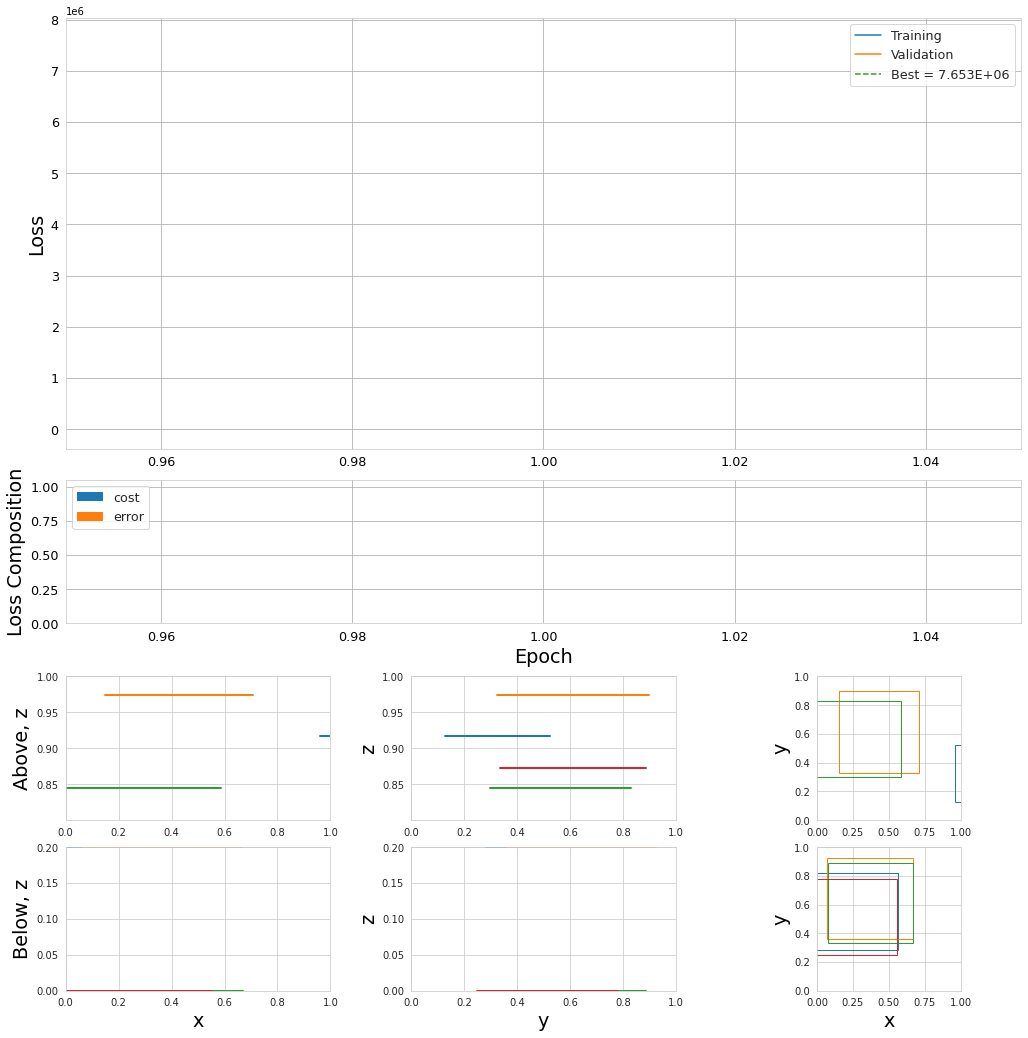

<ipython-input-283-89f8f14c44dc>:174: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


TypeError: nan_to_num(): argument 'input' (position 1) must be Tensor, not NoneType

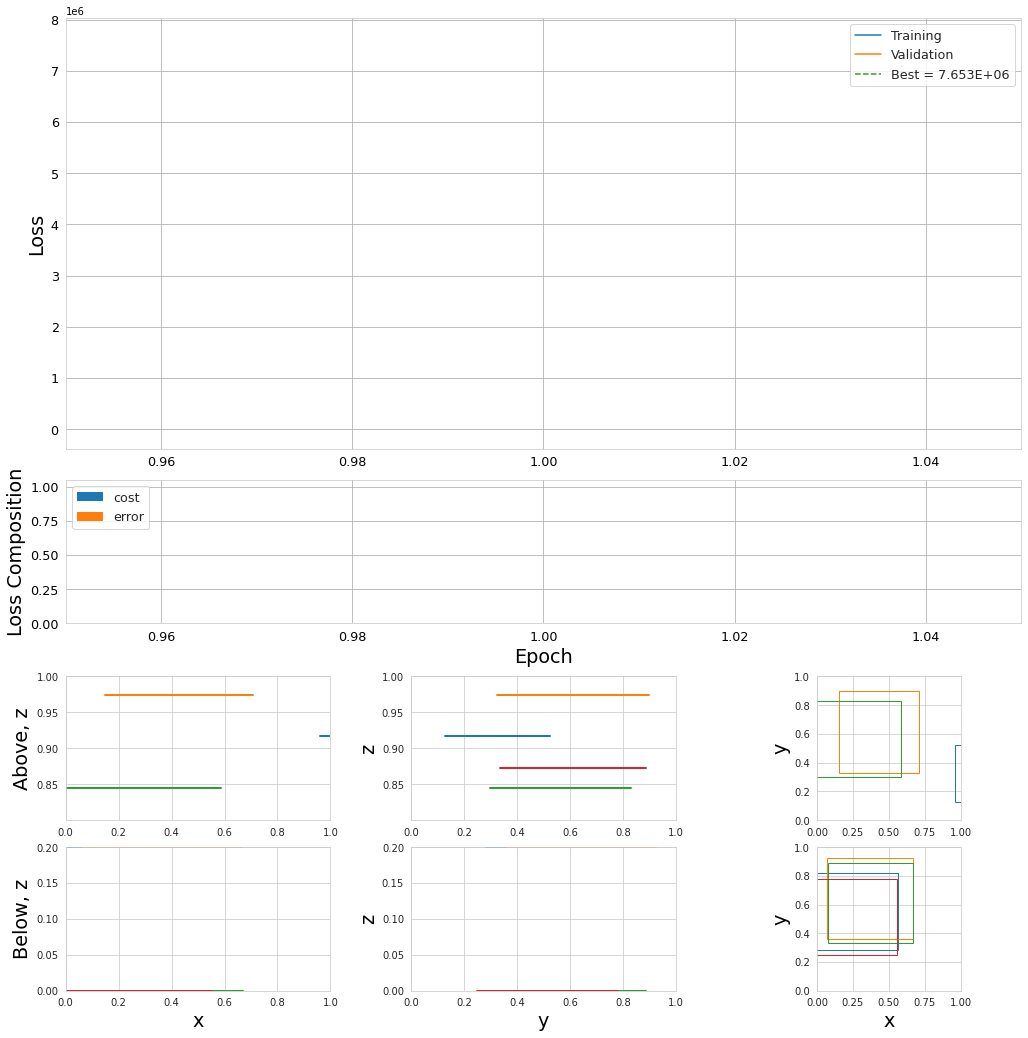

In [290]:
%%time
_ = wrapper.fit(25, n_mu_per_volume=100, mu_bs=100, passive_bs=1, trn_passives=trn_passives, val_passives=trn_passives, cbs=[ml])

In [270]:
volume

Volume(
  (layers): ModuleList(
    (0): DetectorLayer(
      (panels): ModuleList(
        (0): <class '__main__.DetectorPanel'> located at xy=tensor([0.4595, 0.3968]), z=0.9989792704582214, and xy span tensor([0.5192, 0.4291])
        (1): <class '__main__.DetectorPanel'> located at xy=tensor([0.4262, 0.4653]), z=0.9830469489097595, and xy span tensor([0.5447, 0.4778])
        (2): <class '__main__.DetectorPanel'> located at xy=tensor([0.4453, 0.5165]), z=0.8551726937294006, and xy span tensor([0.5370, 0.5102])
        (3): <class '__main__.DetectorPanel'> located at xy=tensor([0.3825, 0.2742]), z=0.801262378692627, and xy span tensor([0.5595, 0.3539])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): DetectorLayer(
      (panels): ModuleList(
        (0): <class '__main__.DetectorPanel'> located at xy=tensor([0.5064, 0.4925]), z=0.19999954104423523, and xy span tensor